## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold,StratifiedKFold, cross_val_score,GridSearchCV
import warnings
warnings.filterwarnings('ignore')
sns.set_style('white')

## Read data

In [2]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [5]:
colors = ['#D92938','#A60522','#273859','#071526']

## Missing values

In [6]:
print("Train: ")
for col in train.columns:
    if train[col].isnull().values.any():
        print(col, train[col].isnull().sum())
      
print("\nTest:")
for col in test.columns:
    if test[col].isnull().values.any():
        print(col, test[col].isnull().sum())

Train: 
Age 177
Cabin 687
Embarked 2

Test:
Age 86
Fare 1
Cabin 327


In [7]:
#filling na values
train['Cabin'] = train['Cabin'].fillna('U')
test['Cabin'] = test['Cabin'].fillna('U')

train['Age'] = train['Age'].fillna( np.mean(train['Age']) )
test['Age'] = test['Age'].fillna( np.mean(test['Age']) )

train['Fare'] = train['Fare'].fillna( np.mean(train['Fare']) )
test['Fare'] = test['Fare'].fillna( np.mean(test['Fare']) )

## EDA and some Feature Engineering

Looking at the chart below, we can notice that we got a higher percentage of males on Titanic!

Text(0.5, 0, '')

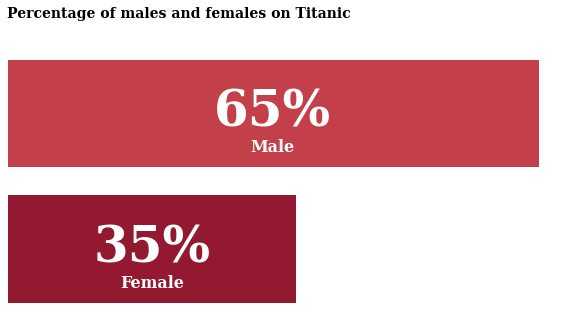

In [8]:
plt.figure(figsize=(10,5))

p = [train['Sex'].value_counts()[0]/sum(train['Sex'].value_counts())*100,
     train['Sex'].value_counts()[1]/sum(train['Sex'].value_counts())*100]

g=sns.barplot(x=p,y=['Male','Female'], palette=colors,orient = 'h')

g.text(0, -0.7, 'Percentage of males and females on Titanic', 
       fontsize=14, fontweight='bold', fontfamily='Serif',color='black')

for i in ['top', 'left', 'right', 'bottom']:
    g.spines[i].set_visible(False)
    
for i in range(2):
    g.annotate(f'{round(p[i])}%', 
                xy=(p[i]/2, i),
                ha = 'center', va='center',fontsize=50, fontweight='bold', 
                fontfamily='Serif', color='white')
    g.annotate('Male' if i==0 else 'Female', 
                xy=(p[i]/2, i+0.25),
                ha = 'center', va='center',fontsize=16, fontweight='bold', 
                fontfamily='Serif', color='white')
    
g.set(xticklabels=[],yticklabels=[])
plt.ylabel('')
plt.xlabel('')

In [9]:
#boolean column for sex
train["bool_sex"] = (train["Sex"] == "male").astype(int)
test["bool_sex"] = (test["Sex"] == "male").astype(int)

Unfortunately we got a higher percentage of people who not Survived!

Text(0.5, 0, '')

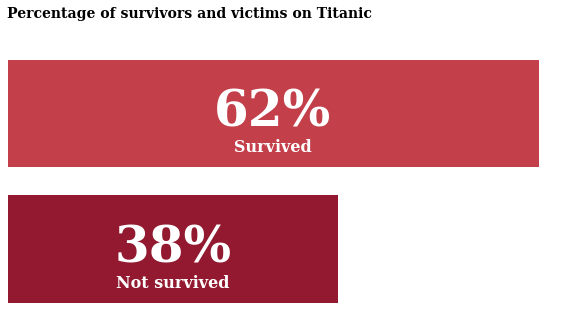

In [10]:
plt.figure(figsize=(10,5))

p = [train['Survived'].value_counts()[0]/sum(train['Survived'].value_counts())*100,
     train['Survived'].value_counts()[1]/sum(train['Survived'].value_counts())*100]

g = sns.barplot(x=p, y=['Survived','Not Survived'],palette=colors)

g.text(0, -0.7, 'Percentage of survivors and victims on Titanic', 
       fontsize=14, fontweight='bold', fontfamily='Serif',color='black')

for i in ['top', 'left', 'right', 'bottom']:
    g.spines[i].set_visible(False)
    
for i in range(2):
    g.annotate(f'{round(p[i])}%', 
                xy=(p[i]/2, i),
                ha = 'center', va='center',fontsize=50, fontweight='bold', 
                fontfamily='Serif', color='white')
    g.annotate('Survived' if i==0 else 'Not survived', 
                xy=(p[i]/2, i+0.25),
                ha = 'center', va='center',fontsize=16, fontweight='bold', 
                fontfamily='Serif', color='white')
    
g.set(xticklabels=[],yticklabels=[])
plt.ylabel('')
plt.xlabel('')

Clearly the sex of the passengers was crucial. The percentage of women surviving is much higher than that of men surviving, as we can see!

Text(0, 0.5, '')

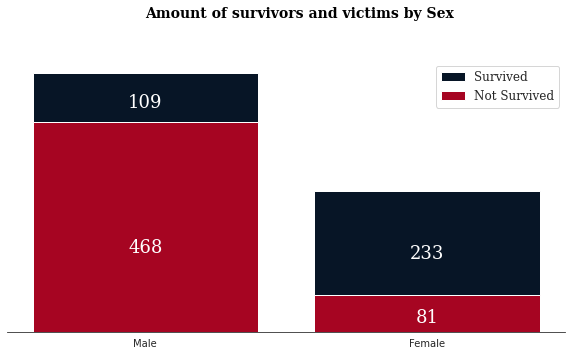

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

d = train['Sex'].value_counts()
d1 = train[ train['Sex'] == 'male' ]['Survived'].value_counts()
d2 = train[ train['Sex'] == 'female' ]['Survived'].value_counts()

g = plt.bar(d.index,d,label='Survived',color=colors[3])
g1 = plt.bar(d.index, [d1[0],d2[0]],label='Not Survived',color=colors[1])

ax.text(0, 700, 'Amount of survivors and victims by Sex ', 
       fontsize=14, fontweight='bold', fontfamily='Serif',color='black')

for i in ['top', 'left', 'right']:
    ax.spines[i].set_visible(False)
    
for i in g1.patches:
    ax.text(i.get_x()+i.get_width()/2,
           i.get_height()/2.5,
           round(i.get_height()),
           fontsize='18',
           fontfamily='Serif',
           color='white',va='center',ha='center')
c=0
for i in g.patches:
    ax.text(i.get_x()+i.get_width()/2,
           g1.patches[c].get_height()+(i.get_height()-g1.patches[c].get_height())/2.5,
           round(i.get_height()-g1.patches[c].get_height()),
           fontsize='18',
           fontfamily='Serif',
           color='white',va='center',ha='center')
    c+=1
    
plt.legend(loc='upper right',prop={'size': 12, 'family': 'Serif'})
ax.set(xticklabels=['Male','Female'],yticklabels=[])
plt.xlabel('')
plt.ylabel('')

Looking at the next chart it's possible to notice that most passengers are adults up to 50 years. It sounds like a good idea stratify the ages in groups to get better visualizations and maybe help in our model.

Text(0, 0.5, '')

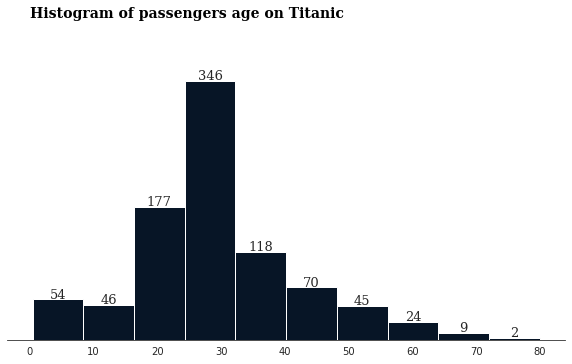

In [12]:
fig, ax = plt.subplots(1, figsize=(10,5))

g=plt.hist(train['Age'],color=colors[3])

ax.text(0, 430, 'Histogram of passengers age on Titanic', 
       fontsize=14, fontweight='bold', fontfamily='Serif',color='black')

for i in ax.patches:
    ax.text(i.get_x()+i.get_width()/2,
           i.get_height()+6,
           round(i.get_height()),
           fontsize='13',
           fontfamily='Serif',va='center',ha='center')
    
for i in ['top', 'right','left']:
    ax.spines[i].set_visible(False)

ax.set(yticklabels=[])
plt.xlabel('')
plt.ylabel('')

In [13]:
train['Child'] = (train['Age'] <= 12).astype(int)
test['Child'] = (test['Age'] <= 12).astype(int)

train['Young'] = train['Age'].apply(lambda x: x> 12 and x<=18).astype(int)
test['Young'] = test['Age'].apply(lambda x: x> 12 and x<=18).astype(int)

train['Adult'] = train['Age'].apply(lambda x: x> 18 and x<=55).astype(int)
test['Adult'] = test['Age'].apply(lambda x: x> 18 and x<=55).astype(int)

train['Old'] = train['Age'].apply(lambda x: x>55).astype(int)
test['Old'] = test['Age'].apply(lambda x: x>55).astype(int)

Looking again at the ages of our passengers, we can clearly see that we have a larger number of adults.



Text(0.5, 0, '')

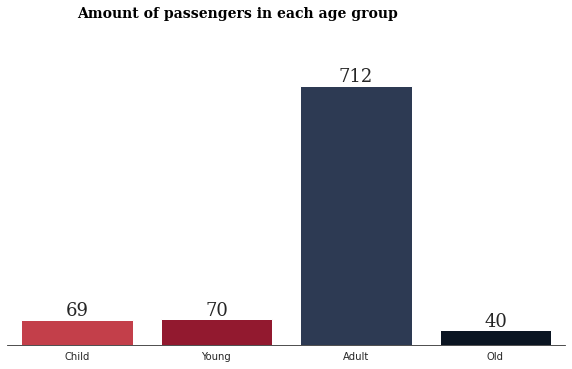

In [14]:
plt.figure(figsize=(10,5))

g= sns.barplot(x=['Child','Young','Adult','Old'],
               y=[sum(train['Child']),sum(train['Young']),
               sum(train['Adult']),sum(train['Old'])],
               palette=colors)

g.text(0, 900,'Amount of passengers in each age group', 
       fontsize=14, fontweight='bold', fontfamily='Serif',color='black')

for i in ['top', 'left', 'right']:
    g.spines[i].set_visible(False)
    
for i in g.patches:
    g.text(i.get_x()+i.get_width()/2,
           i.get_height()+25,
           round(i.get_height()),
           fontsize='18',
           fontfamily='Serif',va='center',ha='center')
    
g.set(yticklabels=[])
plt.ylabel('')
plt.xlabel('')

In the fare histogram we see that the absolute majority of tickets cost less than $ 100. However, we have some tickets that have exceeded that amount.



Text(0, 0.5, '')

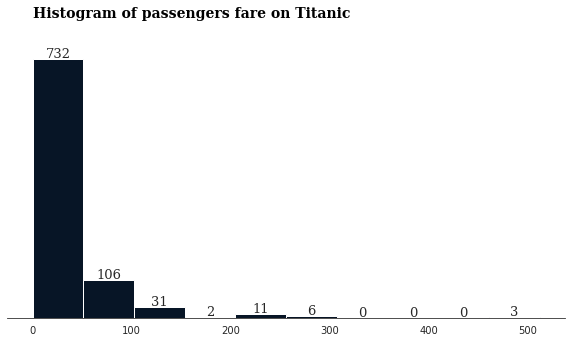

In [15]:
fig, ax = plt.subplots(1, figsize=(10,5))

g=plt.hist(train['Fare'], color=colors[3])

ax.text(0, 850, 'Histogram of passengers fare on Titanic', 
       fontsize=14, fontweight='bold', fontfamily='Serif',color='black')

for i in ax.patches:
    ax.text(i.get_x()+i.get_width()/2,
           i.get_height()+16,
           round(i.get_height()),
           fontsize='13',
           fontfamily='Serif',va='center',ha='center')
    
for i in ['top', 'right','left']:
    ax.spines[i].set_visible(False)

ax.set(yticklabels=[])
plt.xlabel('')
plt.ylabel('')

Categorizing Fare column in >100 or not.

In [16]:
train['cat_fare'] = train['Fare'].apply(lambda x: x>100)
test['cat_fare'] = test['Fare'].apply(lambda x: x>100)

The data also tell us which port a particular passenger embarked on. In a chart that relates this information to the survived information, we realized that the only port in which the majority survived was port "C".

Text(0.5, 0, '')

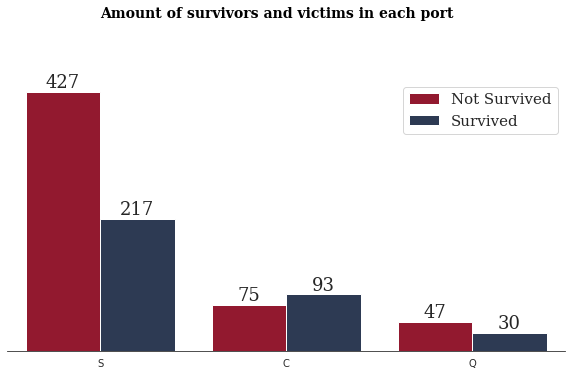

In [17]:
plt.figure(figsize=(10,5))

g=sns.countplot(train['Embarked'],hue=train['Survived'],palette=colors[1:])

g.text(0, 550,'Amount of survivors and victims in each port', 
       fontsize=14, fontweight='bold', fontfamily='Serif',color='black')

for i in ['top', 'left', 'right']:
    g.spines[i].set_visible(False)
    
for i in g.patches:
    g.text(i.get_x()+i.get_width()/2,
           i.get_height()+16,
           round(i.get_height()),
           fontsize='18',
           fontfamily='Serif',va='center',ha='center')
    
g.set(yticklabels=[])
plt.legend(['Not Survived','Survived'],loc='upper right',prop={'size': 15, 'family': 'Serif'})
plt.ylabel('')
plt.xlabel('')

New feature to use the embarked column information.

In [18]:
def emb_feature(x):
    if x=='S':
        return 0
    elif x=='C':
        return 1
    else:
        return 2
train['emb'] = train['Embarked'].apply(emb_feature)
test['emb'] = test['Embarked'].apply(emb_feature)


Looking at the Pclass column, most of the passengers in the first class survived, as we could imagine. The vast majority of passengers in the third class did not survive.



Text(0.5, 0, '')

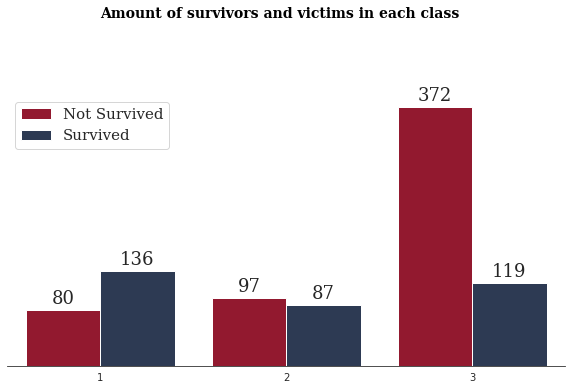

In [19]:
plt.figure(figsize=(10,5))

g=sns.countplot(train['Pclass'],hue=train['Survived'],palette=colors[1:])


g.text(0, 500,'Amount of survivors and victims in each class', 
       fontsize=14, fontweight='bold', fontfamily='Serif',color='black')

for i in ['top', 'left', 'right']:
    g.spines[i].set_visible(False)
    
for i in g.patches:
    g.text(i.get_x()+i.get_width()/2,
           i.get_height()+16,
           round(i.get_height()),
           fontsize='18',
           fontfamily='Serif',va='center',ha='center')
    
plt.legend(['Not Survived','Survived'],loc='upper left',prop={'size': 15, 'family': 'Serif'})
g.set(yticklabels=[])
plt.ylabel('')
plt.xlabel('')

Knowing "sibsp" column counts the number of siblings/spouses aboard the Titanic and "parch" counts the number of parents/children aboard the Titanic I will create a new column to define whether the passenger is boarding alone or not.

In [20]:
train['is_alone'] = (train['SibSp']>0) | (train['Parch']>0)
test['is_alone'] = (test['SibSp']>0) | (test['Parch']>0)

train['fml_size'] = train['SibSp'] + train['Parch'] 
test['fml_size'] = test['SibSp'] + test['Parch'] 

Now, we can see that our graph shows the information that passengers who were not alone died more than those who were.

Text(0, 0.5, '')

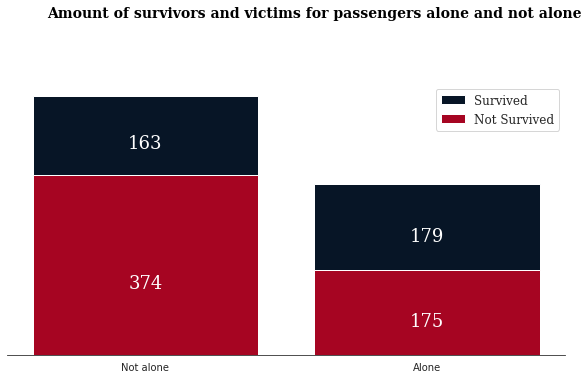

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

d = train['is_alone'].value_counts()
d1 = train[ train['is_alone'] == 0 ]['Survived'].value_counts()
d2 = train[ train['is_alone'] == 1 ]['Survived'].value_counts()

d.index = ['Not alone', 'Alone']
g = plt.bar(d.index,d,label='Survived',color=colors[3])
g1 = plt.bar(d.index, [d1[0],d2[0]],label='Not Survived',color=colors[1])

ax.text(-0.35, 700, 'Amount of survivors and victims for passengers alone and not alone', 
       fontsize=14, fontweight='bold', fontfamily='Serif',color='black')

for i in ['top', 'left', 'right']:
    ax.spines[i].set_visible(False)
    
for i in g1.patches:
    ax.text(i.get_x()+i.get_width()/2,
           i.get_height()/2.5,
           round(i.get_height()),
           fontsize='18',
           fontfamily='Serif',
           color='white',va='center',ha='center')
c=0
for i in g.patches:
    ax.text(i.get_x()+i.get_width()/2,
           g1.patches[c].get_height()+(i.get_height()-g1.patches[c].get_height())/2.5,
           round(i.get_height()-g1.patches[c].get_height()),
           fontsize='18',
           fontfamily='Serif',
           color='white',va='center',ha='center')
    c+=1
    
plt.legend(loc='upper right',prop={'size': 12, 'family': 'Serif'})
ax.set(yticklabels=[])
plt.xlabel('')
plt.ylabel('')

## Validation


In [22]:
cols = ['Pclass','bool_sex','Child','Young','Adult','Old',
        'fml_size','is_alone','cat_fare','emb','SibSp','Parch']
SEED = 30
X = train[cols]
y = train['Survived']

cv = StratifiedKFold(n_splits=5, shuffle=True)

models = [ LogisticRegression(), LinearSVC(), RandomForestClassifier()]
m_name = ['Logistic Regression', 'Linear SVC', 'Random Forest']

i=0
for item in models:
    np.random.seed(SEED)
    results = cross_val_score(item, X, y, cv = cv,scoring = 'accuracy')
    mean = results.mean()
    dv = results.std()
    print('Accuracy - {}: {:.2f}%'.format(m_name[i], mean*100))
    print('Expected accuracy - Model {}: [{:.2f}% ~ {:.2f}%]\n'.format(m_name[i],(mean - 2*dv)*100, (mean + 2*dv)*100))
    i += 1

Accuracy - Logistic Regression: 81.03%
Expected accuracy - Model Logistic Regression: [74.19% ~ 87.88%]

Accuracy - Linear SVC: 81.04%
Expected accuracy - Model Linear SVC: [74.66% ~ 87.41%]

Accuracy - Random Forest: 81.93%
Expected accuracy - Model Random Forest: [75.15% ~ 88.71%]



Random Forest is the best model in our validation. Now, we will do a hyperparameter tuning for the final model. 

This block of code is commented because this cell may take a little while to run (~30 minutes).


 



In [23]:
# param_grid = { 
#     "criterion" : ["gini", "entropy"], 
#     "min_samples_leaf" : [1, 5, 10, 25, 50, 70], 
#     "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], 
#     "n_estimators": [100, 400, 700, 1000, 1500]
# }
# CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), 
#                       param_grid=param_grid, 
#                       cv= 5)
# CV_rfc.fit(X, y)

# CV_rfc.best_params_

## Model

In [24]:
cols = ['Pclass','bool_sex','Child','Young','Adult','Old',
        'fml_size','is_alone','cat_fare','emb','SibSp','Parch']
X = train[cols]
y = train['Survived']

Final model with tuned Random Forest Classifier.

In [25]:
model = RandomForestClassifier(
     min_samples_leaf= 1,
     min_samples_split= 4,
     criterion= 'gini',
     n_estimators= 100
)
model.fit(X,y)
p = model.predict(test[cols])

Generating submission.

In [26]:
sub = pd.Series(p,index=test['PassengerId'],name='Survived')
sub.to_csv('submission.csv',header=True)